# Relation Extraction

## Set variables

In [1]:
logdir = './logs/ELECTRA' # for tensorboard
MODEL_PATH = 'google/electra-base-discriminator'

batch_size = 16
num_train_epochs = 4

Select specific GPU

In [2]:
import os

# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

## Install and import necessary libraries

In [3]:
# ! pip install transformers
# ! pip install pandas
# ! pip install scikit-learn
# ! pip install numpy
# ! pip install torch
# ! pip install optuna
# ! pip install -q tb-nightly
# ! pip install tensorboard
# ! pip install tensorflow

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import shutil
import dill

## Dataset Preprocessing


Dataset config file

In [5]:
root_data_dir = "../../Datasets/BiodivRE-MultiClass/"

### GAD Loading

Data loading utils

In [6]:
def loadData(csv_file_path, header=None, index_col=None):
  dataset_path = os.path.join(root_data_dir, csv_file_path)
  data = pd.read_csv(dataset_path, encoding="latin1", sep=',', header=header, index_col=index_col, names=['Label', 'Sentence'])
  return data

In [7]:
def convert_labels_to_integers(df):
    # Define the mapping
    df['Label'] = df['Label'].replace(np.nan, 0)
    df['Label'] = df['Label'].replace('NA', 0)
    label_mapping = {
        'have': 1,
        'occur_in': 2,
        'influence': 3
    }
    
    # Replace the values in the specified column
    df['Label'] = df['Label'].replace(label_mapping)
    df['Label'] = df['Label'].replace(np.nan, 0)
    
    return df

In [8]:
data_train = loadData(csv_file_path='train.csv', header=None, index_col=None)
data_train = convert_labels_to_integers(data_train)

/tmp/ipykernel_2362988/3573874737.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Label'] = df['Label'].replace(label_mapping)


In [9]:
data_train.head(10)

,Label,Sentence
0,1,Since our hypotheses are based on growth chara...
1,1,"Commands : as.taxo ( ) , divc ( ) ( div_abgd :..."
2,0,We demonstrate that I. noli- tangere and I. te...
3,0,( ppm ) number # decimal st_dev_p_bicar_ppm da...
4,1,-- - Crown length is calculated as the total t...
5,1,"Commands : as.taxo ( ) , divc ( ) Observed num..."
6,3,Features of @MATTER$ / Chargo al ( depth ) inf...
7,1,Spatiotemporal modulation of biodiversity in a...
8,0,Species were removed in a subtractive fashion ...
9,0,"In 18 grazed and 21 improved fallows , we esti..."


In [10]:
data_test = loadData(csv_file_path='test.csv', header=None, index_col=None)
data_test = convert_labels_to_integers(data_test)

/tmp/ipykernel_2362988/3573874737.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Label'] = df['Label'].replace(label_mapping)


In [11]:
data_dev = loadData(csv_file_path='val.csv', header=None, index_col=None)
data_dev = convert_labels_to_integers(data_dev)

/tmp/ipykernel_2362988/3573874737.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Label'] = df['Label'].replace(label_mapping)


In [12]:
data_dev.head(10)

,Label,Sentence
0,0,additional trees aluminium cadmium calcium car...
1,0,-- - 6 digit metal tags starting with 3 were a...
2,1,"In a grassland biodiversity experiment , we ad..."
3,1,This is the first comparative study of the @EN...
4,1,This suggests that the @QUALITY$ contributed b...
5,2,( @ORGANISM$ : species ) The scientific specie...
6,2,countries Reading the Complex Skipper Butterfl...
7,0,Revealing the Appetite of the Marine Aquarium ...
8,0,"forest species , open-habitat species , genera..."
9,0,We demonstrate that I. noli- tangere and I. te...


In [13]:
print(len(data_train), len(data_test), len(data_dev))

3200 400 400


split texts and labels

In [14]:
data_train.columns

Index(['Label', 'Sentence'], dtype='object')

In [15]:
train_texts = data_train[data_train.columns[1]].to_list()
train_labels = data_train[data_train.columns[0]].to_list()

In [16]:
test_texts = data_test[data_test.columns[1]].to_list()
test_labels = data_test[data_test.columns[0]].to_list()

In [17]:
dev_texts = data_dev[data_dev.columns[1]].to_list()
dev_labels = data_dev[data_dev.columns[0]].to_list()

Some visualizations useful for max_len determination, BERT in all cases is limited to 512 word input. After running the below cells, some sentenaces exceeded this limit, we will need truncation during the tokenizer step

In [18]:
plt.style.use("ggplot")

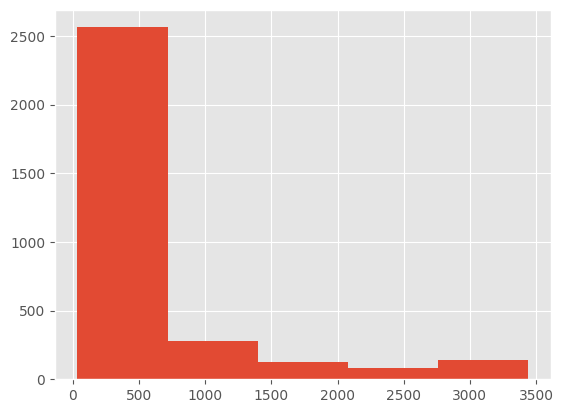

In [19]:
plt.hist([len(s) for s in train_texts], bins=5)
plt.show()

In [20]:
max([len(s) for s in train_texts]) # we will need truncation (automatically on token encodings and manually in the encode_labels function)

3442

In [21]:
max([len(s) for s in test_texts])

3442

In [22]:
max([len(s) for s in dev_texts])

3431

## Explicit Truncation

In [23]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [24]:
train_encodings = tokenizer(train_texts, padding=True, truncation=True, max_length=128)
dev_encodings = tokenizer(dev_texts, padding=True, truncation=True, max_length=128)
test_encodings = tokenizer(test_texts, padding=True, truncation=True, max_length=128)

In [25]:
len(train_encodings[0])

128

### Dataset objects 

Create the dataset objects

In [26]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [27]:
train_dataset = MyDataset(train_encodings, train_labels)
dev_dataset = MyDataset(dev_encodings, dev_labels)
test_dataset = MyDataset(test_encodings, test_labels)

# Hyperparameter Optimization

## Set-up

Instantiating the model

In [28]:
from transformers import AutoModelForSequenceClassification

def model_init():
    return AutoModelForSequenceClassification.from_pretrained(MODEL_PATH, num_labels=4)

Defining the hyperparameter search space

In [29]:
from optuna import Trial
from typing import Dict, Union

def hp_space(trial: Trial) -> Dict[str, Union[float, int, str]]:
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-3, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 3, 10),
    }

Defining the compute_metrics function

In [30]:
from sklearn.metrics import accuracy_score
# from datasets import load_metric

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    # print(labels)
    # print(predictions)
    # Remove ignored index (special tokens)
    # Create a long 1D list of y_true and y_pred
    y_true = []
    y_pred = []
    for pred, lbl in zip(predictions, labels):  
      y_true.append(lbl) 
      y_pred.append(pred)    
    acc = accuracy_score(y_true, y_pred)
    return {    # we can customize this dictionary to include Pr, Recall and F1-Score as well.
        "accuracy": acc,
    }

Clear model directory if it hasn't been cleared yet.

In [31]:
def delete_dir(directory_path):
    if os.path.exists(directory_path):
        try:
            # Remove the directory
            shutil.rmtree(directory_path)
            print(f"Directory '{directory_path}' removed successfully.")
        except Exception as e:
            print(f"Error removing directory '{directory_path}': {e}")
    else:
        print(f"Directory '{directory_path}' does not exist.")

delete_dir("./results")
delete_dir("./re.model")

Directory './results' removed successfully.
Directory './re.model' removed successfully.


In [32]:
from transformers import TrainerCallback, TrainerState

class CleanupCallback(TrainerCallback):
    def on_train_begin(self, args, state, control, **kwargs):
        shutil.rmtree("./results", ignore_errors=True)
        
        global best_trial_accuracy, best_trial_epoch
        best_trial_accuracy = 0.0
        best_trial_epoch = 0

Defining the training arguments

In [33]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from transformers.integrations import TensorBoardCallback

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=num_train_epochs,              # total number of training epochs
    per_device_train_batch_size=batch_size,  # batch size per device during training
    per_device_eval_batch_size=batch_size,   # batch size for evaluation
    gradient_accumulation_steps=4,
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir=logdir,            # directory for storing logs
    logging_steps=10,
    evaluation_strategy = "steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    save_total_limit=2,
    metric_for_best_model="eval_accuracy",
    load_best_model_at_end=True,
    report_to="none"
  )

trainer = Trainer(
    model_init=model_init,                         # the instantiated Transformers model to be trained
    tokenizer=tokenizer,
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset  
    eval_dataset=dev_dataset,           # evaluation dataset
    compute_metrics=compute_metrics,  
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.001), CleanupCallback()], #CleanupCallback()
)

2024-03-30 23:05:44.148386: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-30 23:05:44.390278: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-03-30 23:05:47.340434: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Hyperparameter Search

In [34]:
best_overall_accuracy = 0.0  # Initialize the best accuracy
best_overall_epoch = 0

best_trial_accuracy = 0.0
best_trial_epoch = 0

def compute_objective(metrics):
    global best_overall_accuracy, best_overall_epoch, best_trial_accuracy, best_trial_epoch
    if metrics['eval_accuracy'] > best_trial_accuracy:
        best_trial_accuracy = metrics['eval_accuracy']
        best_trial_epoch = trainer.state.epoch
    if metrics['eval_accuracy'] > best_overall_accuracy:
        best_overall_accuracy = metrics['eval_accuracy']
        best_overall_epoch = trainer.state.epoch
    return best_trial_accuracy

In [35]:
best_run = trainer.hyperparameter_search(
    hp_space=hp_space,
    n_trials=100,
    direction="maximize",
    compute_objective=compute_objective,
)

[I 2024-03-30 23:06:42,401] A new study created in memory with name: no-name-1c5fab56-9387-4255-9b5e-9c07ff4627fa


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.920100,0.907973,0.685000
100,0.835500,0.766539,0.710000
150,0.676000,0.754657,0.732500
200,0.583700,0.641487,0.760000
250,0.488000,0.690011,0.727500


[I 2024-03-30 23:10:28,908] Trial 0 finished with value: 0.76 and parameters: {'learning_rate': 0.00019559291194373135, 'num_train_epochs': 5}. Best is trial 0 with value: 0.76.


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.907100,0.896604,0.685000
100,0.828100,0.792414,0.712500
150,0.645100,0.630920,0.787500
200,0.575400,0.598208,0.782500
250,0.515400,0.919200,0.640000
300,0.523400,0.609211,0.777500


[I 2024-03-30 23:14:59,182] Trial 1 finished with value: 0.7875 and parameters: {'learning_rate': 0.0002570837045930715, 'num_train_epochs': 6}. Best is trial 1 with value: 0.7875.


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.367100,1.360745,0.397500
100,1.232800,1.199807,0.685000
150,1.031900,1.001712,0.685000


[I 2024-03-30 23:17:15,330] Trial 2 finished with value: 0.685 and parameters: {'learning_rate': 6.530354751957613e-06, 'num_train_epochs': 3}. Best is trial 1 with value: 0.7875.


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.200700,1.142111,0.685000
100,0.956400,0.903235,0.685000
150,0.846300,0.846765,0.685000
200,0.753100,0.759358,0.735000
250,0.646500,0.662697,0.767500
300,0.574900,0.614620,0.770000
350,0.538200,0.642221,0.762500
400,0.483700,0.683085,0.732500
450,0.357100,0.609320,0.775000


[I 2024-03-30 23:23:59,253] Trial 3 finished with value: 0.775 and parameters: {'learning_rate': 3.687785754252752e-05, 'num_train_epochs': 9}. Best is trial 1 with value: 0.7875.


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.023700,0.969173,0.685000
100,0.904600,0.828832,0.685000
150,0.771100,0.734925,0.747500
200,0.645100,0.656203,0.767500
250,0.618100,0.664699,0.745000
300,0.496100,0.586869,0.782500
350,0.453100,0.614222,0.775000
400,0.430400,0.674413,0.747500


[I 2024-03-30 23:29:59,159] Trial 4 finished with value: 0.7825 and parameters: {'learning_rate': 8.687943165780239e-05, 'num_train_epochs': 8}. Best is trial 1 with value: 0.7875.


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.386500,1.386833,0.127500


[I 2024-03-30 23:30:44,007] Trial 5 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.311800,1.285633,0.685000
100,1.047900,0.988634,0.685000
150,0.920800,0.904645,0.685000


[I 2024-03-30 23:32:57,515] Trial 6 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.322400,1.300022,0.685000
100,1.070500,1.011243,0.685000
150,0.925900,0.909167,0.685000


[I 2024-03-30 23:35:11,147] Trial 7 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.895900,0.887239,0.685000
100,0.827900,0.753904,0.715000
150,0.638800,0.662327,0.755000
200,0.613900,0.612899,0.760000


[I 2024-03-30 23:38:09,465] Trial 8 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.346000,1.332315,0.660000


[I 2024-03-30 23:38:53,997] Trial 9 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.910300,0.899516,0.685000
100,0.857000,0.818883,0.702500
150,0.674200,0.710906,0.755000
200,0.598800,0.699858,0.730000


[I 2024-03-30 23:41:52,369] Trial 10 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.014600,0.963588,0.685000
100,0.912900,0.841881,0.685000
150,0.766600,0.738752,0.740000
200,0.625200,0.635401,0.757500


[I 2024-03-30 23:44:50,604] Trial 11 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.876600,0.891932,0.685000
100,0.803800,0.869268,0.702500
150,0.992700,0.992255,0.685000


[I 2024-03-30 23:47:04,115] Trial 12 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.110700,1.049310,0.685000
100,0.932200,0.867023,0.685000
150,0.801900,0.771550,0.702500


[I 2024-03-30 23:49:17,780] Trial 13 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.958100,0.934458,0.685000
100,0.883200,0.808112,0.700000
150,0.745300,0.734495,0.732500
200,0.668400,0.680061,0.732500


[I 2024-03-30 23:52:16,150] Trial 14 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.885000,0.895292,0.685000
100,0.976800,0.864955,0.685000
150,0.899800,0.882008,0.685000


[I 2024-03-30 23:54:29,693] Trial 15 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.902800,0.885966,0.685000
100,0.847700,0.800914,0.707500
150,0.654700,0.671777,0.762500
200,0.570500,0.626860,0.777500
250,0.508400,0.709920,0.735000
300,0.458000,0.712842,0.772500


[I 2024-03-30 23:58:57,623] Trial 16 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.394600,1.397717,0.097500


[I 2024-03-30 23:59:42,989] Trial 17 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.060700,0.998045,0.685000
100,0.915900,0.844107,0.685000
150,0.782300,0.756666,0.715000


[I 2024-03-31 00:01:56,145] Trial 18 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.225300,1.171127,0.685000
100,0.965500,0.912445,0.685000
150,0.865600,0.871528,0.685000


[I 2024-03-31 00:04:09,817] Trial 19 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.948500,0.928567,0.685000
100,0.868200,0.785911,0.705000
150,0.743700,0.740993,0.735000
200,0.617500,0.625282,0.770000
250,0.510200,0.655456,0.745000
300,0.461200,0.626441,0.785000


[I 2024-03-31 00:08:40,290] Trial 20 finished with value: 0.785 and parameters: {'learning_rate': 0.00013915238802284348, 'num_train_epochs': 6}. Best is trial 1 with value: 0.7875.


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.931700,0.917412,0.685000
100,0.850000,0.774235,0.715000
150,0.700700,0.734684,0.732500


[I 2024-03-31 00:10:54,398] Trial 21 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.882100,0.872370,0.685000
100,0.820000,0.733553,0.737500
150,0.630600,0.717794,0.725000
200,0.672900,0.677228,0.730000


[I 2024-03-31 00:13:52,791] Trial 22 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.975700,0.942844,0.685000
100,0.879800,0.820310,0.697500
150,0.731600,0.766166,0.707500


[I 2024-03-31 00:16:06,336] Trial 23 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.139700,1.079192,0.685000
100,0.942600,0.880144,0.685000


[I 2024-03-31 00:17:35,314] Trial 24 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.912100,0.900164,0.685000
100,0.832700,0.770590,0.702500
150,0.659400,0.631521,0.777500
200,0.628300,0.621086,0.790000
250,0.508600,0.667845,0.767500
300,0.477900,0.653515,0.802500
350,0.433800,0.652597,0.772500
400,0.671300,0.699458,0.770000
450,0.450900,0.649512,0.762500


[I 2024-03-31 00:24:19,544] Trial 25 finished with value: 0.8025 and parameters: {'learning_rate': 0.00022396422834212594, 'num_train_epochs': 9}. Best is trial 25 with value: 0.8025.


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.908700,0.898195,0.685000
100,0.830900,0.764724,0.702500
150,0.625900,0.637725,0.770000
200,0.621500,0.673812,0.750000
250,0.513800,0.667548,0.772500
300,0.439600,0.598123,0.790000
350,0.430100,0.667922,0.787500
400,0.568700,0.689417,0.795000
450,0.309300,0.788134,0.765000


[I 2024-03-31 00:31:04,425] Trial 26 finished with value: 0.795 and parameters: {'learning_rate': 0.0002359372629063774, 'num_train_epochs': 9}. Best is trial 25 with value: 0.8025.


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.904300,0.888800,0.685000
100,0.843100,0.750315,0.742500
150,0.647200,0.664595,0.742500
200,0.604500,0.650074,0.760000


[I 2024-03-31 00:34:03,284] Trial 27 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.891700,0.873141,0.685000
100,0.827800,0.814044,0.700000


[I 2024-03-31 00:35:32,398] Trial 28 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.912700,0.901965,0.685000
100,0.834700,0.758750,0.717500
150,0.658000,0.666674,0.777500
200,0.588000,0.658786,0.757500
250,0.471900,0.684426,0.747500
300,0.444800,0.652373,0.742500


[I 2024-03-31 00:40:00,787] Trial 29 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.888100,0.903244,0.685000
100,0.935300,0.884153,0.685000


[I 2024-03-31 00:41:30,194] Trial 30 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.925200,0.912676,0.685000
100,0.833500,0.795906,0.707500
150,0.687000,0.688178,0.762500
200,0.593700,0.651299,0.765000


[I 2024-03-31 00:44:28,507] Trial 31 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.944900,0.926060,0.685000
100,0.856600,0.796294,0.700000


[I 2024-03-31 00:45:57,614] Trial 32 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.901100,0.890398,0.685000
100,0.907700,0.849843,0.685000


[I 2024-03-31 00:47:26,528] Trial 33 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.912800,0.901093,0.685000
100,0.826300,0.747193,0.732500
150,0.684800,0.752189,0.755000
200,0.619700,0.691592,0.765000


[I 2024-03-31 00:50:24,639] Trial 34 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.100600,1.037287,0.685000
100,0.927900,0.862158,0.685000


[I 2024-03-31 00:51:53,753] Trial 35 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.270500,1.229574,0.685000
100,0.992600,0.936756,0.685000


[I 2024-03-31 00:53:22,709] Trial 36 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.992900,0.951053,0.685000
100,0.897200,0.820223,0.700000


[I 2024-03-31 00:54:51,639] Trial 37 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.899600,0.895404,0.685000
100,0.857000,0.798241,0.707500
150,0.663200,0.724811,0.742500
200,0.593400,0.639305,0.772500
250,0.510300,0.650416,0.767500
300,0.466200,0.684692,0.727500


[I 2024-03-31 00:59:19,391] Trial 38 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.180000,1.119760,0.685000
100,0.950700,0.894892,0.685000


[I 2024-03-31 01:00:48,787] Trial 39 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.381000,1.379458,0.197500


[I 2024-03-31 01:01:33,022] Trial 40 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.040000,0.980516,0.685000
100,0.916400,0.852570,0.685000


[I 2024-03-31 01:03:01,815] Trial 41 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.939800,0.922518,0.685000
100,0.855800,0.784935,0.712500
150,0.715500,0.724857,0.742500
200,0.586800,0.635674,0.757500


[I 2024-03-31 01:05:59,914] Trial 42 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.972500,0.941571,0.685000
100,0.882800,0.816790,0.697500


[I 2024-03-31 01:07:28,888] Trial 43 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.914700,0.899157,0.685000
100,0.841600,0.766983,0.695000


[I 2024-03-31 01:08:58,206] Trial 44 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.893400,0.885945,0.685000
100,0.814600,0.747836,0.712500
150,0.690600,0.728494,0.727500


[I 2024-03-31 01:11:11,589] Trial 45 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.022400,0.968316,0.685000
100,0.906600,0.836936,0.685000


[I 2024-03-31 01:12:41,277] Trial 46 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.288800,1.254275,0.685000
100,1.010200,0.952701,0.685000


[I 2024-03-31 01:14:10,098] Trial 47 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.894300,0.876492,0.685000
100,0.818600,0.791456,0.715000
150,0.609400,0.711192,0.727500


[I 2024-03-31 01:16:23,526] Trial 48 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.901300,0.894970,0.685000
100,0.811100,0.722450,0.735000
150,0.626800,0.650948,0.760000
200,0.567200,0.632666,0.765000


[I 2024-03-31 01:19:21,856] Trial 49 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.350000,1.337617,0.635000


[I 2024-03-31 01:20:06,347] Trial 50 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.231700,1.179027,0.685000
100,0.967900,0.916386,0.685000


[I 2024-03-31 01:21:34,963] Trial 51 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.073000,1.009791,0.685000
100,0.919800,0.850257,0.685000


[I 2024-03-31 01:23:03,830] Trial 52 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.172100,1.111621,0.685000
100,0.948800,0.894041,0.685000


[I 2024-03-31 01:24:32,630] Trial 53 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.953200,0.931465,0.685000
100,0.860500,0.799243,0.705000
150,0.742800,0.763825,0.732500


[I 2024-03-31 01:26:45,950] Trial 54 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.928100,0.912559,0.685000
100,0.848100,0.759528,0.702500
150,0.679100,0.722138,0.752500
200,0.586000,0.616072,0.782500
250,0.519800,0.672192,0.742500
300,0.520700,0.653755,0.742500


[I 2024-03-31 01:31:14,386] Trial 55 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.880800,0.879026,0.685000
100,0.987300,0.974529,0.685000


[I 2024-03-31 01:32:43,628] Trial 56 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.004600,0.957819,0.685000
100,0.906300,0.826125,0.690000


[I 2024-03-31 01:34:12,492] Trial 57 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.904800,0.893397,0.685000
100,0.808600,0.737071,0.722500
150,0.647500,0.662952,0.762500
200,0.561200,0.669756,0.737500


[I 2024-03-31 01:37:10,611] Trial 58 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.123200,1.062400,0.685000
100,0.937300,0.874405,0.685000


[I 2024-03-31 01:38:39,608] Trial 59 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.886300,0.884998,0.685000
100,0.810600,0.740252,0.742500
150,0.761400,0.725957,0.705000
200,0.856400,0.861538,0.680000


[I 2024-03-31 01:41:38,639] Trial 60 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.915600,0.904505,0.685000
100,0.824700,0.773991,0.712500
150,0.694500,0.706482,0.735000


[I 2024-03-31 01:43:52,411] Trial 61 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.898100,0.887931,0.685000
100,0.827900,0.740723,0.737500
150,0.629000,0.639429,0.762500
200,0.562200,0.648603,0.770000
250,0.481800,0.779257,0.710000


[I 2024-03-31 01:47:37,943] Trial 62 finished with value: 0.77 and parameters: {'learning_rate': 0.0002952049706939229, 'num_train_epochs': 5}. Best is trial 25 with value: 0.8025.


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.327500,1.307034,0.685000
100,1.083200,1.023966,0.685000


[I 2024-03-31 01:49:07,558] Trial 63 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.892700,0.876087,0.685000
100,0.870000,0.784095,0.725000
150,0.691200,0.783488,0.715000


[I 2024-03-31 01:51:20,872] Trial 64 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.900600,0.890221,0.685000
100,0.831800,0.774065,0.702500
150,0.654200,0.716874,0.757500
200,0.608100,0.638401,0.762500


[I 2024-03-31 01:54:19,993] Trial 65 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.971700,0.941123,0.685000
100,0.874900,0.817721,0.702500
150,0.709700,0.712433,0.745000


[I 2024-03-31 01:56:34,581] Trial 66 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.931200,0.914305,0.685000
100,0.855100,0.763152,0.715000
150,0.722900,0.754870,0.737500


[I 2024-03-31 01:58:48,306] Trial 67 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.396400,1.400162,0.097500


[I 2024-03-31 01:59:32,834] Trial 68 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.948100,0.928342,0.685000
100,0.857300,0.794992,0.707500
150,0.735700,0.732466,0.750000
200,0.592700,0.658574,0.772500
250,0.473200,0.648230,0.757500
300,0.440900,0.717980,0.757500


[I 2024-03-31 02:04:00,283] Trial 69 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.893300,0.886689,0.685000
100,0.807400,0.717283,0.720000
150,0.668500,0.691592,0.730000


[I 2024-03-31 02:06:14,762] Trial 70 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.907700,0.897621,0.685000
100,0.820800,0.735104,0.717500
150,0.647000,0.714804,0.740000


[I 2024-03-31 02:08:28,405] Trial 71 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.896000,0.881902,0.685000
100,0.821000,0.715490,0.727500
150,0.651000,0.646986,0.762500
200,0.625200,0.609777,0.762500


[I 2024-03-31 02:11:26,764] Trial 72 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.916500,0.905621,0.685000
100,0.830200,0.765356,0.712500
150,0.649700,0.678952,0.767500
200,0.582500,0.629464,0.770000
250,0.516300,0.701595,0.730000


[I 2024-03-31 02:15:12,238] Trial 73 finished with value: 0.77 and parameters: {'learning_rate': 0.00020571160688411877, 'num_train_epochs': 5}. Best is trial 25 with value: 0.8025.


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.921200,0.907418,0.685000
100,0.834300,0.786634,0.720000
150,0.730000,0.743998,0.735000


[I 2024-03-31 02:17:25,891] Trial 74 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.043800,0.983372,0.685000
100,0.909900,0.843147,0.685000


[I 2024-03-31 02:18:54,976] Trial 75 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.893500,0.879768,0.685000
100,0.820000,0.734998,0.715000
150,0.639400,0.742279,0.722500


[I 2024-03-31 02:21:08,350] Trial 76 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.990700,0.949917,0.685000
100,0.883000,0.823014,0.700000


[I 2024-03-31 02:22:38,074] Trial 77 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.942200,0.924407,0.685000
100,0.853500,0.799504,0.712500
150,0.732400,0.763872,0.735000


[I 2024-03-31 02:24:51,840] Trial 78 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.910100,0.898112,0.685000
100,0.820600,0.772613,0.707500
150,0.631800,0.667045,0.767500
200,0.586900,0.577692,0.777500
250,0.468700,0.768342,0.720000


[I 2024-03-31 02:28:38,169] Trial 79 finished with value: 0.7775 and parameters: {'learning_rate': 0.00025788446947721454, 'num_train_epochs': 5}. Best is trial 25 with value: 0.8025.


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.890600,0.873441,0.685000
100,0.930400,0.882272,0.682500


[I 2024-03-31 02:30:07,342] Trial 80 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.905100,0.893815,0.685000
100,0.822400,0.739731,0.732500
150,0.643000,0.697529,0.760000


[I 2024-03-31 02:32:21,214] Trial 81 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.918500,0.906726,0.685000
100,0.838100,0.783660,0.712500
150,0.665400,0.650721,0.770000
200,0.601300,0.646797,0.762500


[I 2024-03-31 02:35:22,108] Trial 82 finished with value: 0.77 and parameters: {'learning_rate': 0.0001967699064474133, 'num_train_epochs': 4}. Best is trial 25 with value: 0.8025.


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.904700,0.888544,0.685000
100,0.822500,0.788174,0.725000
150,0.709800,0.800377,0.715000


[I 2024-03-31 02:37:36,434] Trial 83 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.896500,0.880944,0.685000
100,0.803100,0.742542,0.700000


[I 2024-03-31 02:39:06,154] Trial 84 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.219700,1.164298,0.685000
100,0.962900,0.909997,0.685000


[I 2024-03-31 02:40:34,978] Trial 85 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.927800,0.912751,0.685000
100,0.854100,0.770855,0.722500
150,0.732600,0.769866,0.735000


[I 2024-03-31 02:42:48,727] Trial 86 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.968300,0.939572,0.685000
100,0.872800,0.829142,0.692500


[I 2024-03-31 02:44:17,765] Trial 87 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.896900,0.888563,0.685000
100,0.807400,0.710178,0.712500
150,0.637200,0.681040,0.755000


[I 2024-03-31 02:46:31,061] Trial 88 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.900300,0.890450,0.685000
100,0.837200,0.750174,0.715000
150,0.620200,0.642042,0.780000
200,0.583300,0.651883,0.737500
250,0.476900,0.653453,0.757500
300,0.409900,0.638873,0.780000


[I 2024-03-31 02:50:59,596] Trial 89 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.101200,1.037820,0.685000
100,0.927700,0.861251,0.685000


[I 2024-03-31 02:52:29,453] Trial 90 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.916000,0.905095,0.685000
100,0.833300,0.775189,0.710000
150,0.676100,0.706138,0.747500


[I 2024-03-31 02:54:42,762] Trial 91 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.911500,0.900447,0.685000
100,0.832500,0.753429,0.720000
150,0.629200,0.649950,0.765000
200,0.629300,0.696798,0.720000


[I 2024-03-31 02:57:41,731] Trial 92 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.940300,0.923146,0.685000
100,0.858900,0.786553,0.717500
150,0.731700,0.756580,0.735000


[I 2024-03-31 02:59:55,248] Trial 93 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.929900,0.916136,0.685000
100,0.856600,0.772685,0.710000
150,0.731200,0.727519,0.750000


[I 2024-03-31 03:02:08,921] Trial 94 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.958100,0.934509,0.685000
100,0.866300,0.798459,0.702500


[I 2024-03-31 03:03:38,033] Trial 95 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.890600,0.879360,0.685000
100,0.889800,0.825648,0.697500


[I 2024-03-31 03:05:06,892] Trial 96 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.019800,0.966708,0.685000
100,0.910800,0.842448,0.685000


[I 2024-03-31 03:06:35,788] Trial 97 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.903700,0.891957,0.685000
100,0.832900,0.739733,0.722500
150,0.696100,0.670870,0.765000
200,0.603700,0.650582,0.760000


[I 2024-03-31 03:09:34,530] Trial 98 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.898100,0.886719,0.685000
100,0.808600,0.754372,0.722500
150,0.624600,0.645437,0.762500


[I 2024-03-31 03:11:48,120] Trial 99 pruned. 


# Fine-tuning With Best Hyperparameters

In [36]:
for n, v in best_run.hyperparameters.items():
    setattr(trainer.args, n, v)

trainer.args.num_train_epochs=best_overall_epoch
trainer.args.report_to="tensorboard"
trainer.add_callback(TensorBoardCallback())

In [37]:
trainer.train()
trainer.evaluate()
trainer.save_model('re.model')

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.912100,0.900164,0.685000
100,0.832700,0.770590,0.702500
150,0.659400,0.631521,0.777500
200,0.628300,0.621086,0.790000
250,0.508600,0.667845,0.767500
300,0.477900,0.653515,0.802500


# Prediction

The use of validation dataset

In [38]:
eval_history = trainer.evaluate()

In [39]:
predictionsOutput = trainer.predict(test_dataset) 

In [40]:
predictionsOutput.predictions.shape

(400, 4)

In [41]:
predictions = predictionsOutput.predictions.argmax(axis=1)

In [42]:
predictions.shape # each of the corresponding tokens has one label which has the highest propability

(400,)

Explore one example of the test dataset (prediction vs. true) lables.

In [43]:
for text, pred, lbl in zip(test_texts, predictions, test_labels):
  print(pred, text)
  print(lbl, text)
  break

1 Selection of competitors : all neighbours within a radius of 2-Jan the height of the target tree were said to be competitors ( target_group : CSP #ERROR! target tree species ) The name consists of the CSP name and the @QUALITY$ of the target @ORGANISM$ around which the area is located .
1 Selection of competitors : all neighbours within a radius of 2-Jan the height of the target tree were said to be competitors ( target_group : CSP #ERROR! target tree species ) The name consists of the CSP name and the @QUALITY$ of the target @ORGANISM$ around which the area is located .


# Evaluation Metrcies 

F1-Score, Precision and Recall, sklearn?

In [44]:
# Create a long 1D list of y_true and y_pred
y_true = []
y_pred = []

for text, pred, lbl in zip(test_texts, predictions, test_labels):
  y_true.append(lbl)
  y_pred.append(pred)

In [45]:
acc = accuracy_score(y_true, y_pred)
print(acc)

0.8


In [46]:
from sklearn.metrics import precision_recall_fscore_support

In [47]:
precision_recall_fscore_support(y_true, y_pred,labels=[0,1])

(array([0.82333333, 0.7       ]),
 array([0.91481481, 0.56451613]),
 array([0.86666667, 0.625     ]),
 array([270,  62]))

In [48]:
from sklearn.metrics import classification_report

In [49]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.91      0.87       270
           1       0.70      0.56      0.62        62
           2       0.74      0.74      0.74        43
           3       0.86      0.24      0.38        25

    accuracy                           0.80       400
   macro avg       0.78      0.62      0.65       400
weighted avg       0.80      0.80      0.79       400



In [50]:
results = classification_report(y_true, y_pred, output_dict=True)
results

{'0': {'precision': 0.8233333333333334,
  'recall': 0.9148148148148149,
  'f1-score': 0.8666666666666667,
  'support': 270.0},
 '1': {'precision': 0.7,
  'recall': 0.5645161290322581,
  'f1-score': 0.625,
  'support': 62.0},
 '2': {'precision': 0.7441860465116279,
  'recall': 0.7441860465116279,
  'f1-score': 0.7441860465116279,
  'support': 43.0},
 '3': {'precision': 0.8571428571428571,
  'recall': 0.24,
  'f1-score': 0.375,
  'support': 25.0},
 'accuracy': 0.8,
 'macro avg': {'precision': 0.7811655592469546,
  'recall': 0.6158792475896753,
  'f1-score': 0.6527131782945736,
  'support': 400.0},
 'weighted avg': {'precision': 0.7978214285714286,
  'recall': 0.8,
  'f1-score': 0.7853125,
  'support': 400.0}}

### Visualizations
Plots of learning curves (loss and accuracy) during training and validation

In [51]:
def plot_dict(history, start_step=10,  step_size=10, use_title=None, use_xlabel=None, use_ylabel=None):
  plt.figure(figsize=(12,12))
  for key, list_val in history.items():
    plt.plot(list_val, label=key)
  plt.title(use_title)
  plt.xlabel(use_xlabel)
  plt.ylabel(use_ylabel, multialignment='center')
  plt.legend()
  plt.show()

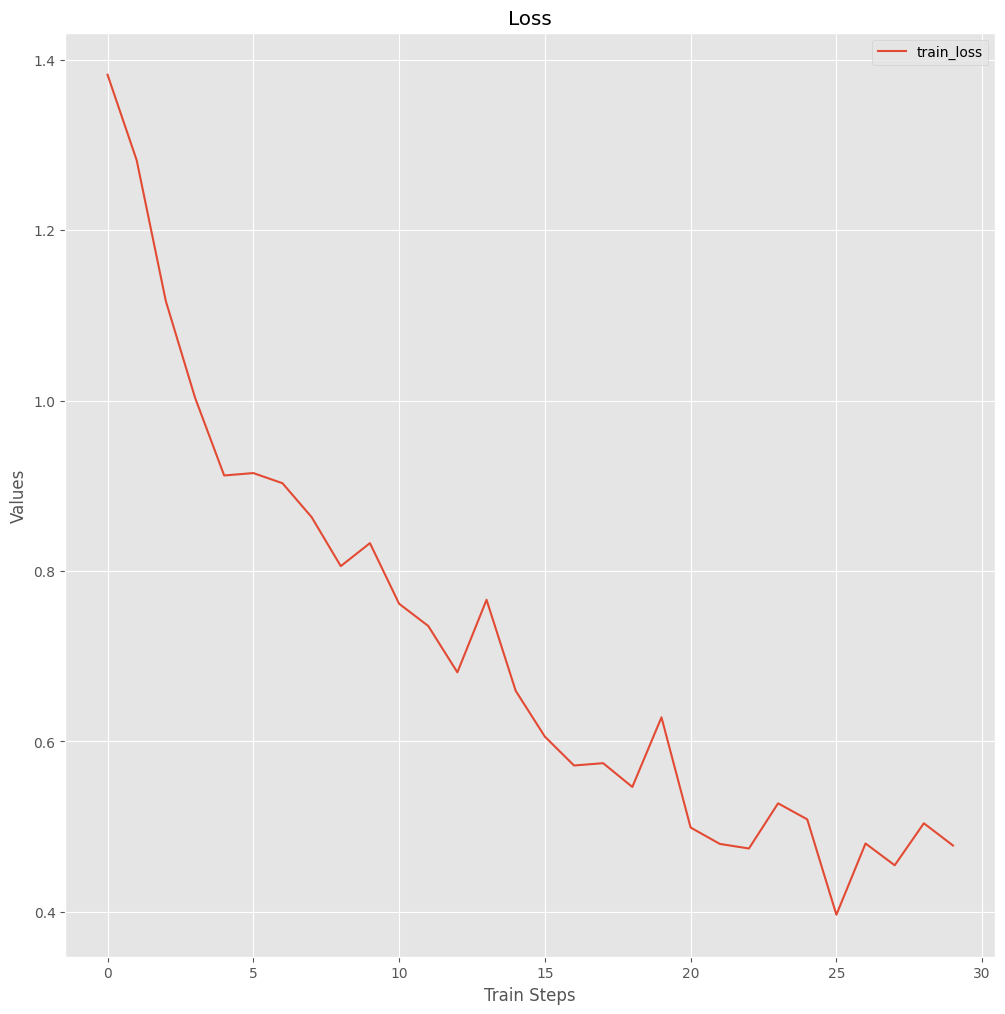

In [52]:
# Keep track of train and evaluate loss.
# loss_history = {'train_loss':[], 'eval_loss':[]}
loss_history = {'train_loss':[]}

# Keep track of train and evaluate accuracy
acc_history = {'train_acc':[], 'eval_acc':[]}

# Loop through each log history.
for log_history in trainer.state.log_history:

  if 'loss' in log_history.keys():
    # Deal with training/eval loss.
    loss_history['train_loss'].append(log_history['loss'])
    # loss_history['eval_loss'].append(log_history['eval_loss'])
    
  elif 'acc' in log_history.keys():
    # Deal with training/eval accuracy.
    loss_history['train_acc'].append(log_history['acc'])
    loss_history['eval_acc'].append(log_history['eval_acc'])

# Plot Losses.
plot_dict(loss_history, start_step=training_args.logging_steps, 
          step_size=training_args.logging_steps, use_title='Loss', 
          use_xlabel='Train Steps', use_ylabel='Values')

In [53]:
eval_history

{'eval_loss': 0.6535148620605469,
 'eval_accuracy': 0.8025,
 'eval_runtime': 1.7333,
 'eval_samples_per_second': 230.779,
 'eval_steps_per_second': 14.424,
 'epoch': 6.0}